In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from puzzle_solver import plot
from puzzle_solver.tile_detector import detect_tiles
import scipy
from scipy.signal import find_peaks, find_peaks_cwt

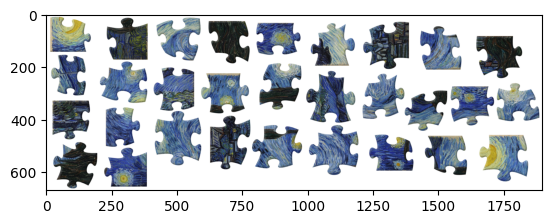

In [2]:
img = cv2.imread("../samples/van-gogh.png")
plot(img)

In [3]:
output = img.copy()

In [4]:
boxes, centroids, num_labels, labels = detect_tiles(img)

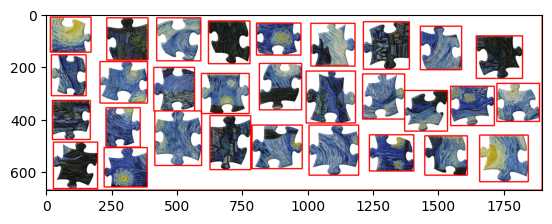

In [5]:
for box in boxes:
    cv2.rectangle(output, box[0], box[1], (0, 0, 255), 3)
plot(output)

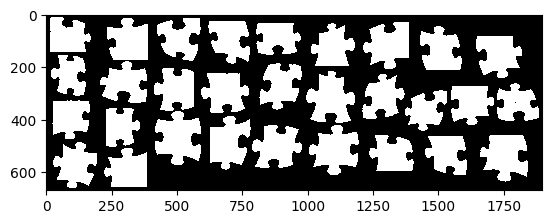

In [6]:
labels_image = np.uint8(labels>0)
plot(labels_image)

In [7]:
# Get contours
"""contours est une liste de liste où chaque liste correspond à un contour et chaque sous-liste est composée de deux éléments et correspond à un pixel"""
contours, hierarchy = cv2.findContours(labels_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("number of puzzle pieces :", len(contours))

## Draw contours
#contours_image = np.zeros_like(img)
#cv2.drawContours(contours_image, contours, -1, (0, 255, 0), 2)
#
## Print contours
#cv2.imshow("Contours", contours_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

number of puzzle pieces : 30


In [8]:
# Get the moments
mu = [None]*len(contours)
for i in range(len(contours)):
    mu[i] = cv2.moments(contours[i])
# Get the mass centers
mc = [None]*len(contours)
for i in range(len(contours)):
    # add 1e-5 to avoid division by zero
    mc[i] = (mu[i]['m10'] / (mu[i]['m00'] + 1e-5), mu[i]['m01'] / (mu[i]['m00'] + 1e-5))

new_centroids = np.array(mc)

### get polar coord

In [9]:
import math

def get_polar_coord(x,y,x_0,y_0):
    rho = math.sqrt((x-x_0)**2 + (y-y_0)**2)
    theta = math.atan2(y-y_0, x-x_0)
    # convertir l'angle en degrés si nécessaire : 
    #theta_degrees = math.degrees(theta)
    return (rho, theta)

def get_xy_coord(rho, theta, x_0, y_0):
    return (rho * math.cos(theta) + x_0, rho*math.sin(theta) + y_0)

In [10]:
polar_coord = []
for i in range(len(new_centroids)):
    # On commence à i+1 car la 1ere cooronées de centroides = centres de l'image totale ? 
    polar_coord.append([])
    x_0 = round(new_centroids[i][0],0)
    y_0 = round(new_centroids[i][1],0)
    for num_pixel in range(len(contours[i])):
        x = contours[i][num_pixel][0][0]
        y = contours[i][num_pixel][0][1]
        (rho, theta) = get_polar_coord(x,y,x_0,y_0)
        polar_coord[i].append((rho,theta))

    polar_coord[i] = np.array(polar_coord[i])
        
polar_coord;

In [11]:
def start_by_min_idx(x):
    argmin = x.argmin()
    N = len(x)
    return [(argmin+i)%N for i in range(N)] 


In [128]:
def angular_dist(ang1, ang2):
    diff = (ang1 - ang2) % (2*np.pi)
    if diff < -np.pi:
        diff = diff + 2*np.pi
    return diff

In [127]:
np.rad2deg(angular_dist(np.pi/2, -np.pi * 3/4))

225.0

In [129]:
def select_peaks_from(peaks, theta, start_idx):
    sol = [peaks[start_idx]]
    penalty = 0
    for _ in range(3):
        goal_theta = theta[sol[-1]] + np.pi/4
        dist = np.array([angular_dist(theta_peak, goal_theta) for theta_peak in theta[peaks]])
        penalty+=dist.min()
        sol.append(peaks[dist.argmin()])
        print(sol, goal_theta, theta[sol[-1]])
    return sol, penalty

def select_peaks(peaks, theta):
    best_sol, best_penalty = None, float("inf")
    for i in range(len(peaks)):
        sol, penalty = select_peaks_from(peaks, theta, i)
        print(penalty)
        if penalty<best_penalty:
            best_penalty = penalty
            best_sol = sol
    return best_sol

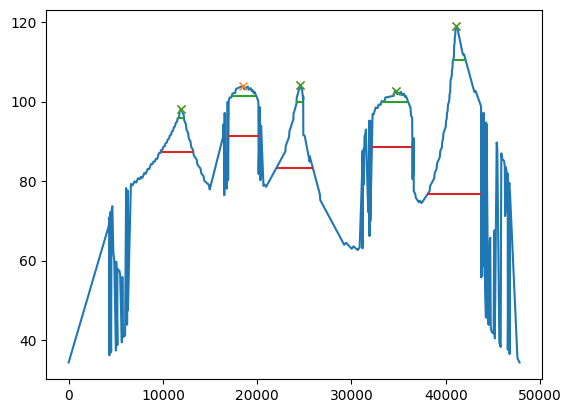

In [201]:
corners = []

x= range(len(polar_coord))
x= [7]
for i in x:
    rho = polar_coord[i][:, 0]
    theta = polar_coord[i][:, 1]

    # Resamp
    idx= np.argsort(theta)
    theta_resamp = np.arange(theta.min(), theta.max(), 1e-4)
    rho_resamp = np.interp(theta_resamp, theta[idx], rho[idx])

    idx = start_by_min_idx(rho_resamp)
    rho_resamp= rho_resamp[idx]
    theta_resamp = theta_resamp[idx]
    # Find peaks
    peaks, _ = find_peaks(rho_resamp, height=np.percentile(rho_resamp, 50), width=1500, rel_height=0.5)

    top_width = scipy.signal.peak_widths(rho_resamp, peaks, rel_height=0.1)
    middle_width = scipy.signal.peak_widths(rho_resamp, peaks, rel_height=0.5)
    corner_peaks = peaks[np.argsort(top_width[0]/middle_width[0])[:4]]

    plt.plot(rho_resamp)
    plt.plot(peaks, rho_resamp[peaks], "x")
    plt.hlines(*top_width[1:], color="C2")
    plt.hlines(*middle_width[1:], color="C3")
    plt.plot(corner_peaks, rho_resamp[corner_peaks], "x")

    local_corners = []
    for peak in corner_peaks:
        corner_rho = rho_resamp[peak]
        corner_theta = theta_resamp[peak]
        corner_x, corner_y = get_xy_coord(corner_rho, corner_theta, new_centroids[i][0], new_centroids[i][1])
        local_corners.append([corner_x, corner_y])
    corners.append(local_corners)

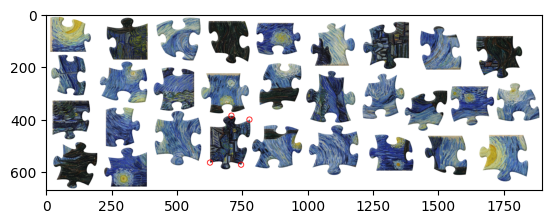

In [202]:
corner_img = img.copy()

i = 0
for corner in corners[i]:
    cv2.circle(corner_img, np.array(corner).astype(int), 10, (0,0,255), thickness=2)

plot(corner_img)

In [193]:
corner_img = img.copy()

for local_corner in corners[:]:
    for corner in local_corner:
        cv2.circle(corner_img, np.array(corner).astype(int), 10, (0,0,255), thickness=2)

plot(corner_img)

IndexError: list index out of range